# Sistema de Detecção e Reconhecimento Facial

## Projeto: Detecção e Reconhecimento Facial usando LFW Dataset

**Tipo:** Aprendizado Supervisionado  
**Base de dados:** LFW (Labeled Faces in the Wild)  
**Descrição:** Sistema que detecta rostos e reconhece pessoas em imagens ou vídeo

In [1]:
# Instalação de dependências
%pip install scikit-learn scikit-image opencv-python mtcnn tensorflow matplotlib numpy pandas

In [2]:
# Importação de bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import cv2
from mtcnn import MTCNN
import os
import warnings
warnings.filterwarnings('ignore')

## 1. Carregamento e Preparação dos Dados LFW

In [3]:
# Carregar dataset LFW
# min_faces_per_person: mínimo de faces por pessoa (filtra pessoas com poucas imagens)
# resize: redimensiona as imagens para acelerar o processamento
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Informações sobre o dataset
n_samples, h, w = lfw_people.images.shape
n_features = h * w
n_classes = lfw_people.target_names.shape[0]

print(f"\nDataset carregado:")
print(f"  - Número de amostras: {n_samples}")
print(f"  - Dimensões das imagens: {h}x{w}")
print(f"  - Número de features: {n_features}")
print(f"  - Número de classes (pessoas): {n_classes}")
print(f"\nPessoas no dataset:")
for i, name in enumerate(lfw_people.target_names):
    print(f"  {i}: {name}")

# Dados e labels
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names


Dataset carregado:
  - Número de amostras: 1288
  - Dimensões das imagens: 50x37
  - Número de features: 1850
  - Número de classes (pessoas): 7

Pessoas no dataset:
  0: Ariel Sharon
  1: Colin Powell
  2: Donald Rumsfeld
  3: George W Bush
  4: Gerhard Schroeder
  5: Hugo Chavez
  6: Tony Blair


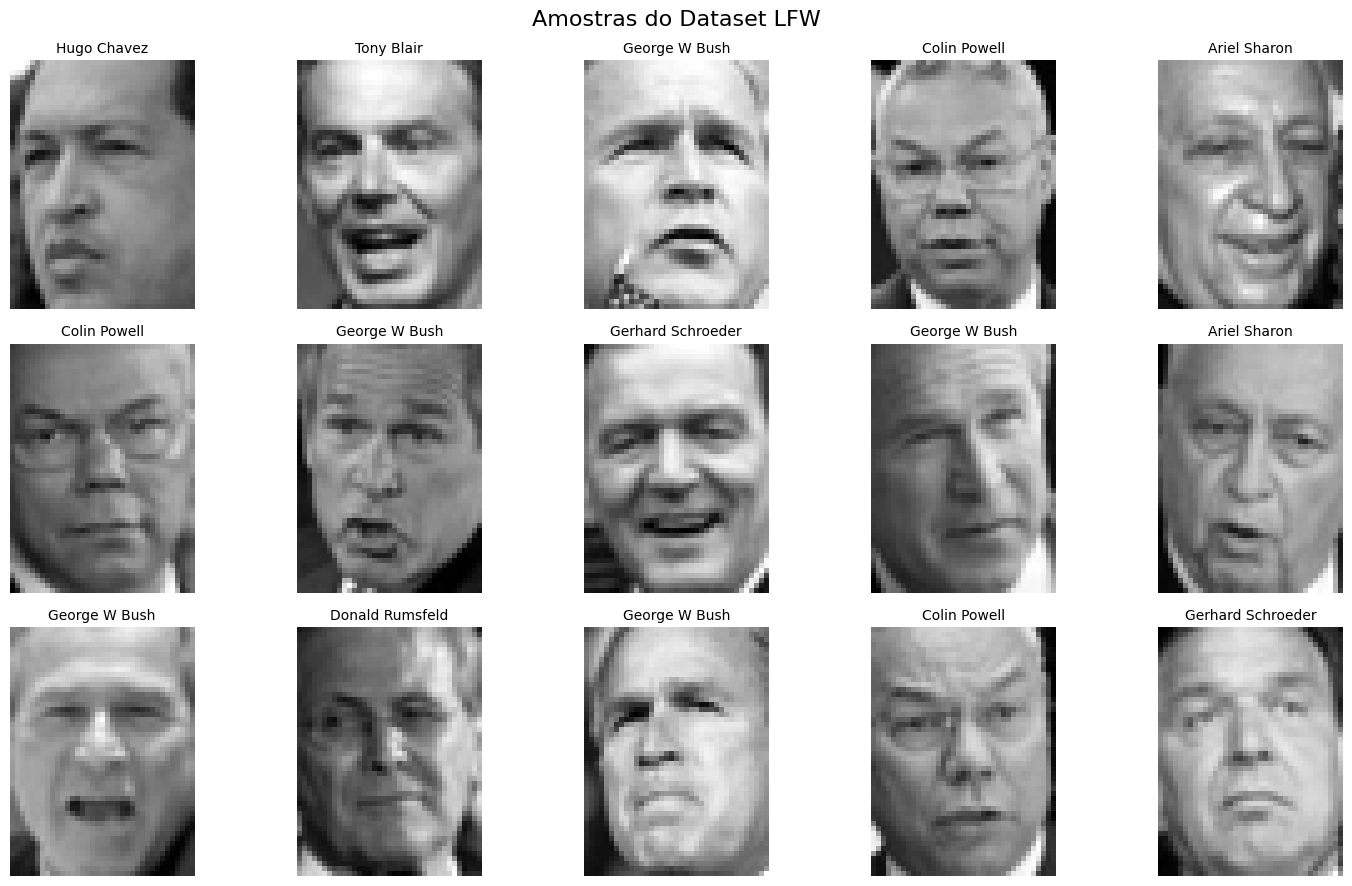

In [4]:
# Visualizar algumas imagens do dataset
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Amostras do Dataset LFW', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < n_samples:
        ax.imshow(X[i].reshape((h, w)), cmap='gray')
        ax.set_title(f'{target_names[y[i]]}', fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()
